In [1]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import random
import argparse
import networkx as nx
from itertools import combinations
import time

In [2]:
import myWalksat as mw

In [3]:
filepath = "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5001.cnf"
max_tries = 10
max_flips = 100000
probability = 0.5
# coloringA1_heuristic0","coloringA1_heuristic1","coloringA1_heuristic2","coloringA1_heuristic3
mode = ["walksat"]
mode = mode[0]
# Outputs: 
print(mw.API(filepath, max_tries, max_flips, probability, mode))

(857.8, 1.0, 915.8386102365415, 3191, 857.8, 915.8386102365415, 0.0, 0.0)


In [4]:
# 11/11/2024 2:27pm
# Running single shot experiments with this and plotting them.
np.random.seed(1337)  
random.seed(1337)  

def read_dimacs(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                parts = line.strip().split()
                if len(parts) >= 4:
                    _, _, variables, _ = parts[:4]
                    num_vars = int(variables)
                else:
                    raise ValueError("Invalid CNF file format in 'p' line.")
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                # Remove the trailing 0 if present
                if clause and clause[-1] == 0:
                    clause = clause[:-1]
                if clause:
                    clauses.append(clause)
    return num_vars, clauses

def evaluate_clause(clause, assignment):
    return any(
        (var > 0 and assignment.get(abs(var), False)) or
        (var < 0 and not assignment.get(abs(var), False))
        for var in clause
    )

def get_unsatisfied_clauses(clauses, assignment):
    return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

def get_variables(clauses):
    return set(abs(var) for clause in clauses for var in clause)

def flip_variable(assignment, var):
    assignment[var] = not assignment[var]

def GenerateColors(clauses):
    variables = set(abs(literal) for clause in clauses for literal in clause)
   
    G = nx.Graph()
    G.add_nodes_from(variables)  # Variable adjacency graph

    # If variables appear in the same clause, make an edge
    for clause in clauses:
        vars_in_clause = set(abs(literal) for literal in clause)
        for var1, var2 in combinations(vars_in_clause, 2):
            G.add_edge(var1, var2)

    # Greedy coloring , return dictionary of unique colors (0 to n) for each node
    colors = nx.coloring.greedy_color(G, strategy='largest_first')
    return colors

# Algorithm A1 Steps:
# 1) Random assignment
# 2) Gather UNSAT clauses
# 3) From the UNSAT clauses, pick a number say 3 clauses at random. These 3 are the same number of colors.
# 3a) For a clause, either pick a variable at random to pick 
# 3b) Or, from the clause, pick the variable with the least break value
# 4) Gather all the picked variables into a list, this is the candidate list of variables. 
# 5) Heuristics:
# 5a) Flip variables of the color represented with the largest number of variables
# 5b) Randomly
# 5c) Randomly pick variavbles of a color to flip
# 5d) Only pick the first candidate variable
# 6) Additionally, near convergence turn the heuristics off and go back to WalkSAT+SKC.  NOTE: not implemented yet
# 8) END 

# Old version with 'loops' inner loop.
def AlgorithmA1(clauses, colors, max_tries, max_loops, p, heuristic_mode=0):
    """    
    clauses: array of clauses from read_cnf() 
    colors: dictionary of color memberships from GenerateColors()
    max_tries: integer of max restarts for algorithm
    max_loops: integer of iterations of algorithm for a given try
    p: probability of greedy vs random selection
    heuristic_mode: 
        0 = greedy in colors from candidate variables to flip
        1 = random from candidate variables to flip
        2 = pick a random color from candidate variables to flip
        3 = always pick first candidate variable in candidate variables to flip
    """
    flips = 0
    variables = np.array(sorted(get_variables(clauses))) # Sorted list of variables
    # 1-based indexing, because 0 in cnf files is used for line breaks
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color

    # Get the number of unique colors
    unique_colors = np.unique(color_array[color_array > 0])
    
    for _try in range(max_tries):
        # 1) Random assignment
        assignment = np.random.choice([True, False], size=num_vars + 1)  # 1 based indexing
        # Changed it to a vectorized version instead of hash maps to make faster tts

        for _loop in range(max_loops):
            # 2) Gather UNSAT clauses
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause]  # Get assignment values
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                # If none evaluate to 1, add to unsat index
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices:
                return assignment[1:], _try, _loop, flips  # Success, return

            # 3) From the UNSAT clauses, pick candidate clauses based on how many colors
            random_samples_count = min(len(unique_colors), len(unsat_indices))
            # Ensure we don't sample more clauses than there are UNSAT clauses
            # this was a bug in the other implementation as well.
            selected_indices = np.random.choice(unsat_indices, size=random_samples_count, replace=False)
            selected_clauses = [clauses[i] for i in selected_indices]

            cc_candidates_to_flip = []
            for clause in selected_clauses:
                variables_in_clause = np.abs(np.array(clause, dtype=int))
                
                # Pick a random variable of the clause for a candidate variable 
                if random.random() < p:
                    # Randomly pick a variable from the clause
                    x = np.random.choice(variables_in_clause)
                    cc_candidates_to_flip.append((x, color_array[x]))
                
                # Or pick variable with least break-count
                else:
                    break_counts = []
                    # Break-count is the number of clauses that become unsatisfied when flipping x
                    for x in variables_in_clause:
                        # Flip variable
                        assignment[x] = ~assignment[x]
                        # Evaluate the number of clauses that become unsatisfied
                        num_new_unsat = 0
                        # Same as before...
                        for clause_check in clauses: 
                            literals_check = np.array(clause_check, dtype=int)
                            vars_in_clause_check = np.abs(literals_check).astype(int)
                            signs_check = literals_check > 0
                            clause_values_check = assignment[vars_in_clause_check]
                            clause_evaluation_check = np.where(signs_check, clause_values_check, ~clause_values_check)
                            if not np.any(clause_evaluation_check):
                                num_new_unsat += 1

                        break_counts.append(num_new_unsat)
                        # Flip variable back
                        assignment[x] = ~assignment[x]

                    # Find variables with least break count
                    min_break = np.min(break_counts)
                    min_indices = np.where(break_counts == min_break)[0]
                    
                    # Pick one index at random if there is more than one this is the tiebreaker
                    idx_min = np.random.choice(min_indices)
                    x = variables_in_clause[idx_min]
                    cc_candidates_to_flip.append((x, color_array[x]))

            # 4) Gather all the picked variables into the candidate list of variables
            color_to_candidates = {}
            for x, color in cc_candidates_to_flip:
                color_to_candidates.setdefault(color, []).append(x)

            # 5) Heuristically pick which variables to flip:
            if heuristic_mode == 0:
                # 5a) Flip variables of the color with the largest number of variables
                selected_color = max(color_to_candidates.keys(), key=lambda c: len(color_to_candidates[c]))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
            elif heuristic_mode == 1:
                # 5b) Randomly pick a variable from candidate variables to flip
                var_to_flip = np.random.choice([x for x, _ in cc_candidates_to_flip])
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
            elif heuristic_mode == 2:
                # 5c) Randomly pick a color, flip all variables of that color
                selected_color = np.random.choice(list(color_to_candidates.keys()))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
            elif heuristic_mode == 3:
                # 5d) Always pick the first candidate variable to flip
                var_to_flip = cc_candidates_to_flip[0][0]
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1

    return "FAIL"


In [5]:
import math
filepath = "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5001.cnf"

try:
    num_vars, clauses = read_dimacs(filepath)
except Exception as e:
    print(f"Error reading CNF file: {e}")
    raise ValueError
    
start_color_time = time.perf_counter()
colors = GenerateColors(clauses)
end_color_time = time.perf_counter()
time_color = end_color_time - start_color_time

max_loops = math.floor(max_flips / len(colors)) #2000 for uf20
max_tries = 1
probability = 0.5

#AlgorithmA1(clauses, colors, max_tries, max_loops, p, heuristic_mode=0)
start_colorwalksat_process_time = time.perf_counter()
result = AlgorithmA1(clauses, colors, max_tries, max_loops, probability, heuristic_mode=1)
end_colorwalksat_process_time = time.perf_counter()
time_colorwalksat = end_colorwalksat_process_time - start_colorwalksat_process_time

if result != "FAIL":
    SAT = 1
    print(time_colorwalksat, time_color, result[1], result[2], result[3])
else:
    print(0,0,0,0,0) # No satisfying assignment found within the given limits


6.021797588095069 0.0012013865634799004 0 550 550


In [ ]:
import math
np.random.seed(1337)  
random.seed(1337)  

filepaths = ["/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5001.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5002.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5003.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5004.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5005.cnf",]

results_nov8 = []
for filepath in filepaths:
    try:
        num_vars, clauses = read_dimacs(filepath)
    except Exception as e:
        print(f"Error reading CNF file: {e}")
        raise ValueError
        
    colors = GenerateColors(clauses)
    max_loops = math.floor(max_flips / len(colors)) #2000 for uf20
    max_tries = 1
    probability = 0.5
    max_flips = 100000

    #AlgorithmA1(clauses, colors, max_tries, max_loops, p, heuristic_mode=1)
    result = AlgorithmA1(clauses, colors, max_tries, max_flips, probability, heuristic_mode=3)

    if result != "FAIL":
        SAT = 1
        #assignment, try, loop, flips
        results_nov8.append([result[1], result[2], result[3]])
    else:
        results_nov8.append([0,0,0]) # No satisfying assignment found within the given limits


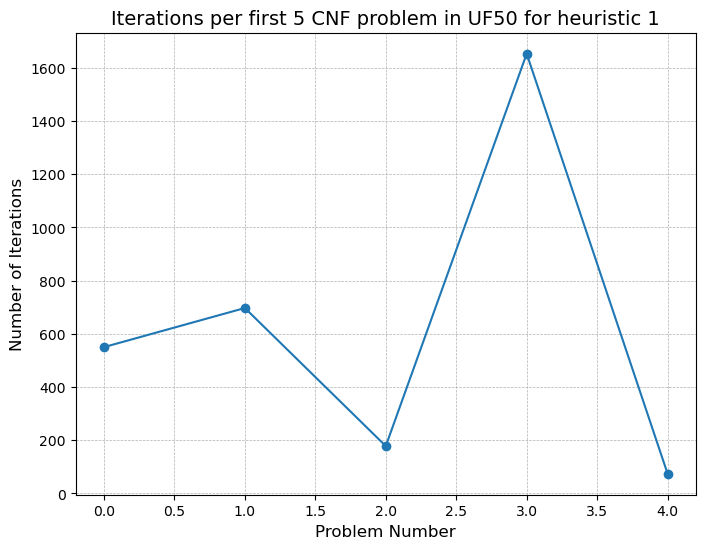

In [ ]:
tempnov8 = [results_nov8[0][1], results_nov8[1][1],results_nov8[2][1], results_nov8[3][1], results_nov8[4][1]]
plt.figure(figsize=(8, 6))
plt.plot(tempnov8, marker='o', linestyle='-')
plt.xlabel('Problem Number', fontsize=12)
plt.ylabel('Number of Iterations', fontsize=12)
plt.title('Iterations per first 5 CNF problem in UF50 for heuristic 3', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [ ]:
# now, modifying the A1 to remove the extra loops part
# 11/11/24 4:05pm

# Renamed 'loops' to '_flips' to stay with the convention

# 11/11/2024 5:03pm
# My idea was to see if the loop '_loops' was any different than the one
# for "flips"; but the problem here is that they are not, in the structure they
# are the same

# The main thing though is that PER MAXFLIP ITER in WalkSAT, there is ONLY one flip allowed
# (actual, phase changing flip)
# Meanwhile, in A1, with the correct heuristic (1 or 3) you ALSO only have one flip allowed
# 
def AlgorithmA1Iter(clauses, colors, max_tries, max_flips, p, heuristic_mode=0):
    flips = 0
    variables = np.array(sorted(get_variables(clauses)))
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color

    unique_colors = np.unique(color_array[color_array > 0])
    
    for _try in range(max_tries):
        assignment = np.random.choice([True, False], size=num_vars + 1) 

        for _flip in range(max_flips):
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause] 
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices:
                return assignment[1:], _try, _flip, flips  # Success, return

            random_samples_count = min(len(unique_colors), len(unsat_indices)) #either sample n_colors or min(unsatclauses)

            # Random samples without replacement, change this to experiment with
            # taking off the start of the array (selectedindeces[0]) or end of it (selectedindeces[-1])
            selected_indices = np.random.choice(unsat_indices, size=random_samples_count, replace=False)
            selected_clauses = [clauses[i] for i in selected_indices]

            cc_candidates_to_flip = [] # candidate variables to flip
            for clause in selected_clauses: #say up to 10 for uf50
                variables_in_clause = np.abs(np.array(clause, dtype=int))
                if random.random() < p:
                    x = np.random.choice(variables_in_clause)
                    cc_candidates_to_flip.append((x, color_array[x]))
                
                else:
                    break_counts = []
                    for x in variables_in_clause:
                        assignment[x] = ~assignment[x] #invert assignment for a given variable
                        num_new_unsat = 0 #then check how many clauses get unsat
                        for clause_check in clauses: #calculate the break count
                            literals_check = np.array(clause_check, dtype=int)
                            vars_in_clause_check = np.abs(literals_check).astype(int)
                            signs_check = literals_check > 0
                            clause_values_check = assignment[vars_in_clause_check]
                            clause_evaluation_check = np.where(signs_check, clause_values_check, ~clause_values_check)
                            if not np.any(clause_evaluation_check):
                                num_new_unsat += 1

                        break_counts.append(num_new_unsat)
                        assignment[x] = ~assignment[x]

                    min_break = np.min(break_counts)
                    min_indices = np.where(break_counts == min_break)[0]
                    # if there is a tie, choose uniformly at random, else this is just the min break one
                    idx_min = np.random.choice(min_indices)
                    x = variables_in_clause[idx_min]
                    cc_candidates_to_flip.append((x, color_array[x])) # add it to candidates to flip

            color_to_candidates = {} #dictionary of (color : candidate variable)
            for x, color in cc_candidates_to_flip:
                color_to_candidates.setdefault(color, []).append(x)

            if heuristic_mode == 0:
                # choose candidate variables to flip with most color representation
                selected_color = max(color_to_candidates.keys(), key=lambda c: len(color_to_candidates[c]))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
            elif heuristic_mode == 1:
                # randomly pick a variable from the candidate variables to flip uniformly at random
                var_to_flip = np.random.choice([x for x, _ in cc_candidates_to_flip])
                assignment[var_to_flip] = ~assignment[var_to_flip] #flip the assignment for the variable
                flips += 1
            elif heuristic_mode == 2:
                # uniformly at random pick a color from those present in the candidate variables to flip
                # flip all candidate variables of that color
                selected_color = np.random.choice(list(color_to_candidates.keys()))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
            elif heuristic_mode == 3:
                # always pick the first candidate variable and flip it for real
                var_to_flip = cc_candidates_to_flip[0][0]
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1

            # then, once we reach this point, increase iteration count by one
            # i.e. increase _flip by one

            # In contrast to regular walksat (below)
            # here we can take multiple flips (ACTUAL VARIABLE FLIPS) at once, which increments
            # the 'flips' count
            # which is NOT the same as the iteration count
            # which is _flip , to keep up with the convention from walksat

    return "FAIL"


# General idea here, remove all the heuristics, this should have the same
# number of flips and iterations as walksat.
def WalksatEquivalentOfColoring(clauses, colors, max_tries, max_flips, p):
    flips = 0
    variables = np.array(sorted(get_variables(clauses)))
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color

    unique_colors = np.unique(color_array[color_array > 0])
    
    for _try in range(max_tries):
        assignment = np.random.choice([True, False], size=num_vars + 1) 

        for _flip in range(max_flips):
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause] 
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices:
                return assignment[1:], _try, _flip, flips  # Success, return

            random_samples_count = min(len(unique_colors), len(unsat_indices)) #either sample n_colors or min(unsatclauses)

            # Random samples without replacement, change this to experiment with
            # taking off the start of the array (selectedindeces[0]) or end of it (selectedindeces[-1])
            selected_indices = np.random.choice(unsat_indices, size=random_samples_count, replace=False)
            selected_clauses = [clauses[i] for i in selected_indices]

            cc_candidates_to_flip = [] # candidate variables to flip
            for clause in selected_clauses: #say up to 10 for uf50
                variables_in_clause = np.abs(np.array(clause, dtype=int))
                if random.random() < p:
                    x = np.random.choice(variables_in_clause)
                    cc_candidates_to_flip.append((x, color_array[x]))
                
                else:
                    break_counts = []
                    for x in variables_in_clause:
                        assignment[x] = ~assignment[x] #invert assignment for a given variable
                        num_new_unsat = 0 #then check how many clauses get unsat
                        for clause_check in clauses: #calculate the break count
                            literals_check = np.array(clause_check, dtype=int)
                            vars_in_clause_check = np.abs(literals_check).astype(int)
                            signs_check = literals_check > 0
                            clause_values_check = assignment[vars_in_clause_check]
                            clause_evaluation_check = np.where(signs_check, clause_values_check, ~clause_values_check)
                            if not np.any(clause_evaluation_check):
                                num_new_unsat += 1

                        break_counts.append(num_new_unsat)
                        assignment[x] = ~assignment[x]

                    min_break = np.min(break_counts)
                    min_indices = np.where(break_counts == min_break)[0]
                    # if there is a tie, choose uniformly at random, else this is just the min break one
                    idx_min = np.random.choice(min_indices)
                    x = variables_in_clause[idx_min]
                    cc_candidates_to_flip.append((x, color_array[x])) # add it to candidates to flip

            color_to_candidates = {} #dictionary of (color : candidate variable)
            for x, color in cc_candidates_to_flip:
                color_to_candidates.setdefault(color, []).append(x)

            # Now as in WalkSAT, flip everything that you chose before.
            # Because each of the iterations in 'clause in selected_clauses'
            # is basically an iteration of WALKSAT

            vars_to_flip = [x for x, _ in cc_candidates_to_flip]
            assignment[vars_to_flip] = ~assignment[vars_to_flip]
            flips += len(vars_to_flip)

    return "FAIL"


def walkSAT(clauses, max_tries, max_flips, p):
    flips = 0
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _Tries in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _Flips in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment, _Tries, _Flips, flips  # Found a satisfying assignment
            
            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip
                
                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)
            flips += 1

    return "FAIL"


In [75]:
import math
random.seed(1337)  
np.random.seed(1337)
filepaths = ["/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5001.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5002.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5003.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5004.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5005.cnf",]

results_nov11 = []
for filepath in filepaths:
    try:
        num_vars, clauses = read_dimacs(filepath)
    except Exception as e:
        print(f"Error reading CNF file: {e}")
        raise ValueError
    
    # same setup as before.
    max_flips = 100000
    max_tries = 1
    probability = 0.5

    #AlgorithmA1(clauses, colors, max_tries, max_loops, p, heuristic_mode=0)
    result = WalksatEquivalentOfColoring(clauses, colors, max_tries, max_flips, probability)

    if result != "FAIL":
        SAT = 1
        #assignment, try, loop, flips
        results_nov11.append([result[1], result[2], result[3]])
    else:
        results_nov11.append([0,0,0]) # No satisfying assignment found within the given limits


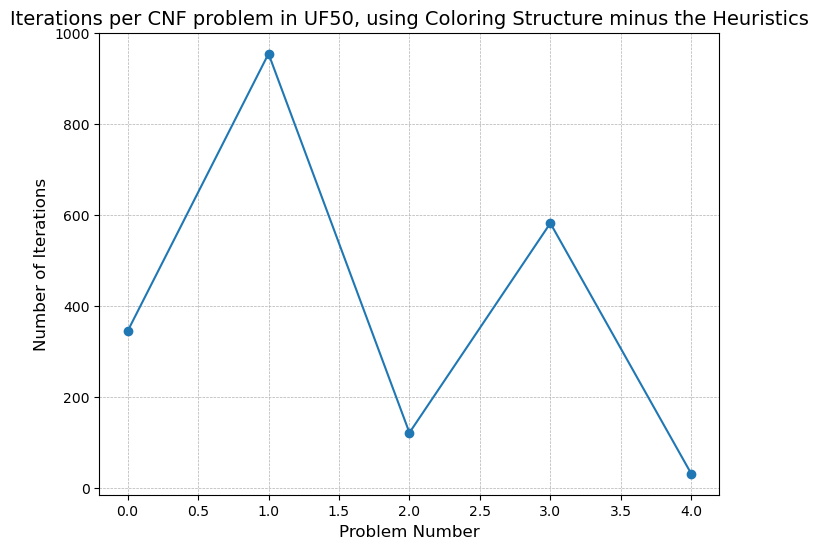

In [70]:
tempnov11 = [results_nov11[0][1], results_nov11[1][1],results_nov11[2][1], results_nov11[3][1], results_nov11[4][1]]
plt.figure(figsize=(8, 6))
plt.plot(tempnov11, marker='o', linestyle='-')
plt.xlabel('Problem Number', fontsize=12)
plt.ylabel('Number of Iterations', fontsize=12)
plt.title('Iterations per CNF problem in UF50, using Coloring Structure minus the Heuristics', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [76]:
import math
random.seed(1337)  
np.random.seed(1337)
filepaths = ["/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5001.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5002.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5003.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5004.cnf",
             "/home/dae/SatExperiments/juniper/uf50suiteSATLIB/uf5005.cnf",]

results_nov11_walksat = []
for filepath in filepaths:
    try:
        num_vars, clauses = read_dimacs(filepath)
    except Exception as e:
        print(f"Error reading CNF file: {e}")
        raise ValueError
    
    # same setup as before.
    max_flips = 100000
    max_tries = 1
    probability = 0.5

    #AlgorithmA1(clauses, colors, max_tries, max_loops, p, heuristic_mode=0)
    result = walkSAT(clauses, max_tries, max_flips, probability)

    if result != "FAIL":
        SAT = 1
        #assignment, try, loop, flips
        results_nov11_walksat.append([result[1], result[2], result[3]])
    else:
        results_nov11_walksat.append([0,0,0]) # No satisfying assignment found within the given limits


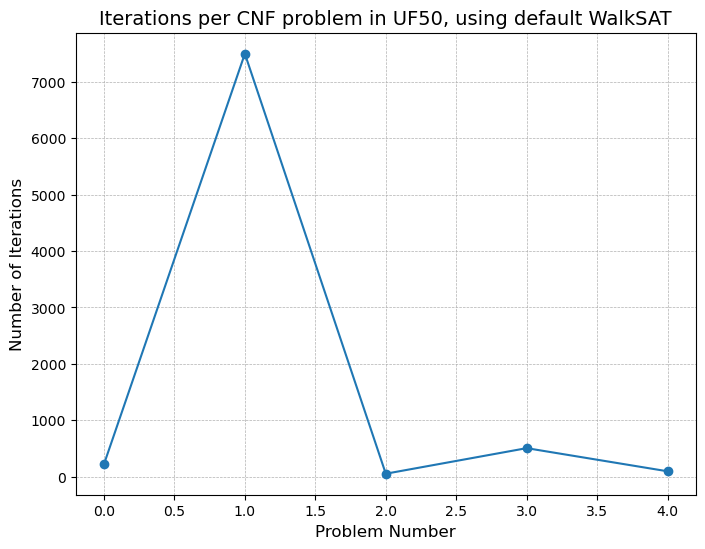

In [78]:
tempnov11walksat = [results_nov11_walksat[0][1], results_nov11_walksat[1][1],results_nov11_walksat[2][1], results_nov11_walksat[3][1], results_nov11_walksat[4][1]]
plt.figure(figsize=(8, 6))
plt.plot(tempnov11walksat, marker='o', linestyle='-')
plt.xlabel('Problem Number', fontsize=12)
plt.ylabel('Number of Iterations', fontsize=12)
plt.title('Iterations per CNF problem in UF50, using default WalkSAT', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [4]:
def read_dimacs(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                _, _, variables, _ = line.split()
                num_vars = int(variables)
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                clauses.append(clause)
    return num_vars, clauses

num_vars, clauses = read_dimacs("/home/dae/SatExperiments/juniper/easiestcnf.cnf")

{6: 0, 7: 1, 8: 2, 10: 0, 1: 0, 2: 1, 3: 2, 4: 2, 5: 1, 9: 2, 11: 1, 12: 1}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


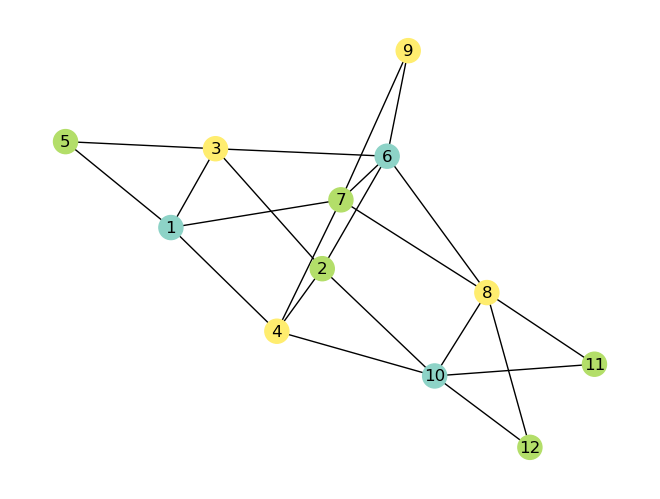

In [17]:
# The hidden culprit: this graph is not doing what you think it is ;)
num_vars, clauses = read_dimacs("/home/dae/SatExperiments/juniper/easiestcnf.cnf")
variables = set(abs(literal) for clause in clauses for literal in clause)
variables.remove(0)
# Variable adjacency graph
G = nx.Graph()
G.add_nodes_from(variables)

# Edges between variables that appear together in a clause
for clause in clauses:
    vars_in_clause = set(abs(literal) for literal in clause)
    vars_in_clause.remove(0)
    for var1, var2 in combinations(vars_in_clause, 2):
        G.add_edge(var1, var2)

# Greedy coloring , returns dictionary of unique colors (0 to n) for each node
colors = nx.coloring.greedy_color(G, strategy='largest_first')

print(colors)
print(variables)
color_values = [colors[node] for node in G.nodes()]

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=color_values, cmap=plt.cm.Set3)
plt.show()


In [6]:
import random

# Initial, correlated implementation
def ColorWalkSAT(clauses, colors, max_tries, max_loops, p):

    # Same as before
    def evaluate_clause(clause, assignment):
        return any(
            (var > 0 and assignment.get(abs(var), False)) or
            (var < 0 and not assignment.get(abs(var), False))
            for var in clause
        )

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]
    
    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)
    
    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]
    
    variables = list(get_variables(clauses))
    
    # Group variables by color
    color_vars = {}
    for var in variables:
        color = colors.get(var, None)
        if color is not None:
            color_vars.setdefault(color, []).append(var)
        else:
            # Handle variables without a color assignment
            color_vars.setdefault('no_color', []).append(var)

    for _ in range(max_tries):

        # We still start with a random phase
        assignment = {var: random.choice([True, False]) for var in variables}

        for _ in range(max_loops):
            
            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            
            if not unsatisfied:
                return assignment  # Found a satisfying assignment

            # Iterate over colors
            # This can be broken down into one per color, or in parallel instead of pipelined.

            for color in color_vars:
                vars_in_color = color_vars[color]
                # Find unsatisfied clauses involving variables of this color
                unsat_clauses_in_color = [
                    clause for clause in unsatisfied
                    if any(abs(var) in vars_in_color for var in clause)
                ]

                if not unsat_clauses_in_color:
                    continue  # No unsatisfied clauses involving this color

                # Randomly select one unsatisfied clause which has this color present (at least one literal has the color)
                clause = random.choice(unsat_clauses_in_color)

                if random.random() < p:
                    # Flip a random variable from the clause if and only if it also has the given color.
                    vars_in_clause_and_color = [
                        abs(var) for var in clause if abs(var) in vars_in_color
                    ]
                    var_to_flip = random.choice(vars_in_clause_and_color)
                else:
                    # Flip the variable that minimizes the number of unsatisfied clauses if flipped
                    # Has to be one of the ones from a given color
                    
                    break_counts = []
                    for var in clause:
                        var = abs(var)
                        if var in vars_in_color:
                            assignment[var] = not assignment[var]
                            num_unsat = len(get_unsatisfied_clauses(clauses, assignment))
                            break_counts.append((num_unsat, var))
                            assignment[var] = not assignment[var]  # Undo the flip
                    if not break_counts:
                        continue
                    min_break = min(break_counts, key=lambda x: x[0])
                    vars_with_min_break = [
                        var for count, var in break_counts if count == min_break[0]
                    ]
                    var_to_flip = random.choice(vars_with_min_break)

                flip_variable(assignment, var_to_flip)
    
    return "FAIL"


# Parameters
max_tries = 10
max_loops = 100
p = 0.5
colors = {1: 0, 2: 1, 3: 2, 8: 2, 9: 1, 10: 0, 4: 3, 11: 3, 5: 2, 6: 1, 7: 0}

# Running WalkSAT
result = ColorWalkSAT(clauses, colors, max_tries, max_loops, p)
if result != "FAIL":
    print("SAT:")
    for var in sorted(result):
        print(f"Variable {var} (Color {colors.get(var, 'N/A')}): {result[var]}")
else:
    print("No satisfying assignment found within the given limits.")

No satisfying assignment found within the given limits.


In [7]:
def read_dimacs(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                _, _, variables, _ = line.split()
                num_vars = int(variables)
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                clauses.append(clause)
    return num_vars, clauses

In [8]:
num_vars, clauses = read_dimacs("/home/dae/SatExperiments/uf50suiteSATLIB/uf5001.cnf")
variables = set(abs(literal) for clause in clauses for literal in clause)

# Variable adjacency graph
G = nx.Graph()
G.add_nodes_from(variables)

# Edges between variables that appear together in a clause
for clause in clauses:
    vars_in_clause = set(abs(literal) for literal in clause)
    for var1, var2 in combinations(vars_in_clause, 2):
        G.add_edge(var1, var2)

# Greedy coloring , returns dictionary of unique colors (0 to n) for each node
colors = nx.coloring.greedy_color(G, strategy='largest_first')


In [9]:
def task(color, assignment, color_vars):
        def evaluate_clause(clause, assignment):
            return any(
                (var > 0 and assignment.get(abs(var), False)) or
                (var < 0 and not assignment.get(abs(var), False))
                for var in clause
            )


        def get_unsatisfied_clauses(clauses, assignment):
             return [clause for clause in clauses if not evaluate_clause(clause, assignment)]
        
        def flip_variable(assignment, var):
             assignment[var] = not assignment[var]
        
        unsatisfied = get_unsatisfied_clauses(clauses, assignment)
        
        if not unsatisfied:
            return assignment  # Found a satisfying assignment

        vars_in_color = color_vars[color]
        # Find unsatisfied clauses involving variables of this color
        unsat_clauses_in_color = [
            clause for clause in unsatisfied
            if any(abs(var) in vars_in_color for var in clause)
        ]

        if not unsat_clauses_in_color:
            return  # No unsatisfied clauses involving this color

        # Randomly select one unsatisfied clause which has this color present (at least one literal has the color)
        clause = random.choice(unsat_clauses_in_color)

        if random.random() < p:
            # Flip a random variable from the clause if and only if it also has the given color.
            vars_in_clause_and_color = [
                abs(var) for var in clause if abs(var) in vars_in_color
            ]
            var_to_flip = random.choice(vars_in_clause_and_color)
        else:
            # Flip the variable that minimizes the number of unsatisfied clauses if flipped
            # Has to be one of the ones from a given color
            # Changing so it does not matter what color you are
            
            break_counts = []
            for var in clause:
                var = abs(var)
                if var in vars_in_color: # comment this to make only the random flip prioritize color half/half algorithm
                    assignment[var] = not assignment[var]
                    num_unsat = len(get_unsatisfied_clauses(clauses, assignment))
                    break_counts.append((num_unsat, var))
                    assignment[var] = not assignment[var]  # Undo the flip
            if not break_counts:
                return
            min_break = min(break_counts, key=lambda x: x[0])
            vars_with_min_break = [
                var for count, var in break_counts if count == min_break[0]
            ]
            var_to_flip = random.choice(vars_with_min_break)

        flip_variable(assignment, var_to_flip)


In [10]:
import random
import subprocess
import multiprocessing


# Now, making the inside of the for loop atomic then multiprocessing the atoms
"""

process = multiprocessing.Process(target=task)

def ColorWalkSAT(clauses, colors, max_tries, max_loops, p):

    # Same as before
    def evaluate_clause(clause, assignment):
        return any(
            (var > 0 and assignment.get(abs(var), False)) or
            (var < 0 and not assignment.get(abs(var), False))
            for var in clause
        )

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]
    
    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)
    
    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]
    
    variables = list(get_variables(clauses))
    
    # Group variables by color
    color_vars = {}
    for var in variables:
        color = colors.get(var, None)
        if color is not None:
            color_vars.setdefault(color, []).append(var)
        else:
            # Handle variables without a color assignment
            color_vars.setdefault('no_color', []).append(var)

    for _ in range(max_tries):

        # We still start with a random phase
        assignment = {var: random.choice([True, False]) for var in variables}

        for _ in range(max_loops):
            process = multiprocessing.Process(target=task, args=(color, assignment, color_vars))
            process.start()
            
    return "FAIL"


# Parameters
max_tries = 100
max_loops = 100000
p = 0.5


# Running WalkSAT
result = ColorWalkSAT(clauses, colors, max_tries, max_loops, p)

# Half and half is way faster but less parallel maybe? I need to run each instance
# of the for loop as an independent process !!!!!
# Yes each color becomes its own process "colorX" and it communicates pipelining to a parent
# A parent node that does the outer loop

if result != "FAIL":
    print("SAT:")
    for var in sorted(result):
        print(f"Variable {var} (Color {colors.get(var, 'N/A')}): {result[var]}")
else:
    print("No satisfying assignment found within the given limits.")
    """

'\n\nprocess = multiprocessing.Process(target=task)\n\ndef ColorWalkSAT(clauses, colors, max_tries, max_loops, p):\n\n    # Same as before\n    def evaluate_clause(clause, assignment):\n        return any(\n            (var > 0 and assignment.get(abs(var), False)) or\n            (var < 0 and not assignment.get(abs(var), False))\n            for var in clause\n        )\n\n    def get_unsatisfied_clauses(clauses, assignment):\n        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]\n    \n    def get_variables(clauses):\n        return set(abs(var) for clause in clauses for var in clause)\n    \n    def flip_variable(assignment, var):\n        assignment[var] = not assignment[var]\n    \n    variables = list(get_variables(clauses))\n    \n    # Group variables by color\n    color_vars = {}\n    for var in variables:\n        color = colors.get(var, None)\n        if color is not None:\n            color_vars.setdefault(color, []).append(var)\n        el